# Analysing Traffic Violations from a JSON File

In this project, we will look at a dataset that contains information on traffic violations in Montgomery County, Maryland.

The data contains information about where the violation happened, the type of car, demographics on the person receiving the violation, and other interesting information. 

We can answer the following questions using this dataset, including:

- What types of cars are most likely to be pulled over for speeding?
- What times of day are police most active?
- How common are "speed traps"? Or are tickets spread pretty evenly in terms of geography?
- What are the most common things people are pulled over for?

Unfortunately, we don't know the structure of JSON file, so it's best to do some exploration first.

## Exploring the JSON Data

Even though the JSON file is only 600MB, we'll assume it's much larger so we can explore how analysing a JSON file that doesn't fit into memory might work. 

We can analyse the JSON file using standard command line tools, or explore the file in Notepad

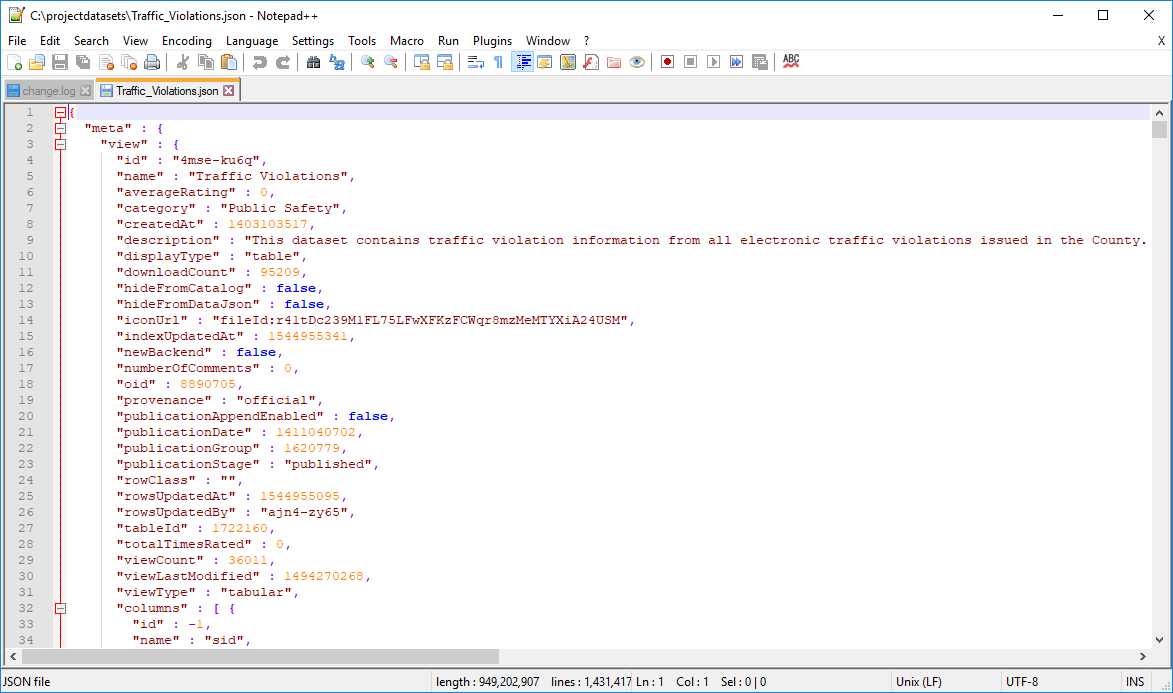

## JSON File Analysis

We can see the JSON data is a dictionary, and well formatted. 'meta' is a top level key, and is indented two spaces.

In the command prompt, we can get all top level keys by using the 'grep' command to print any lines that have two leading spaces

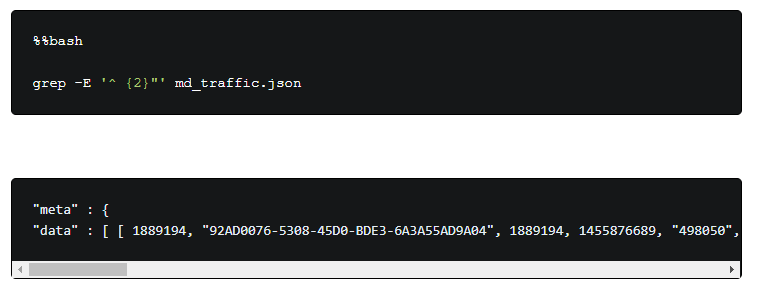


Above, we can see that 'meta' and 'data' are top level keys in the JSON file. 

A list of lists appears to be associated with data, which likely contains each record. The truncated view of the data may look like:

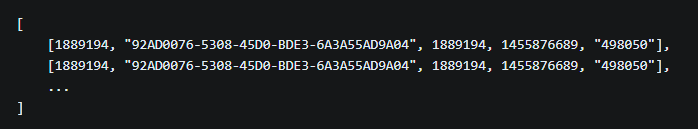

We're just missing the column headers. We may be able to find this information under the 'meta' key.

From the 'head' command, there are at least 3 levels of keys, with meta containing a key view, which contains the keys id, name, averageRating and others. We can print out the full key structure of the JSON file by using grep to print out any lines with 2-6 leading spaces:

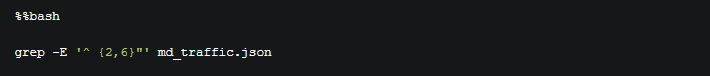

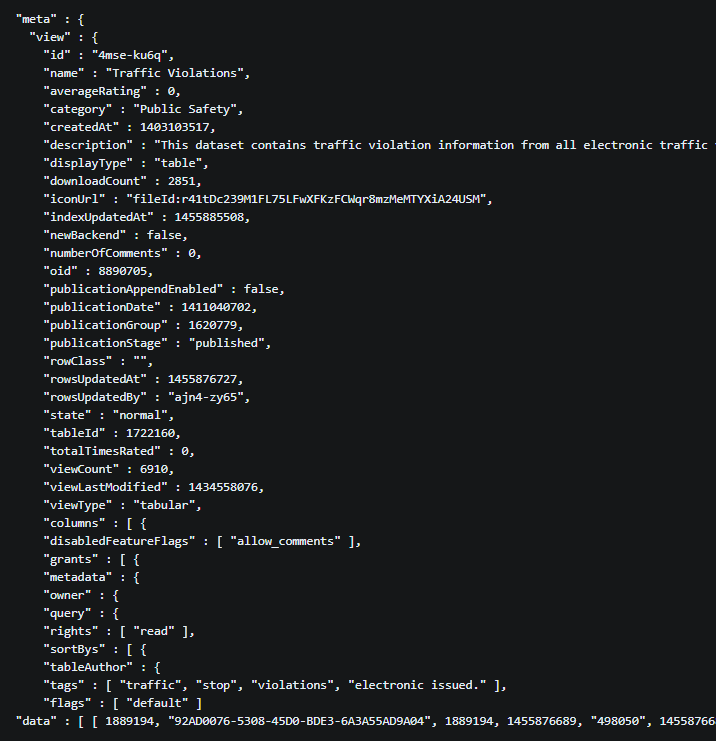

Above shows the full key structure, and tell us which parts of the JSON file are relevant. The 'columns' key looks interesting, as it potentially contains information on the columns.

## Extracting Information on the Columns

We know which key contains information on the columns, so we will read that information in (iteratively in in a memory-efficient way), as the JSON file won't fit in memory.

We can do this using the 'ijson' package, which will iteratively parse the JSON file instead of reading it all in at once. This is slower than directly reading the whole file in, but it enables us to work with large files that can't fit in memory.

In [1]:
import ijson

filename = r"C:\projectdatasets\Traffic_Violations.json"
with open(filename, 'r') as f:
    objects = ijson.items(f, 'meta.view.columns.item')
    columns = list(objects)

Above, we open the JSON file, and use the 'items' method in ijson to extract a list from the file. 

We specify the path to the list using the meta.view.columns notation, which means we extract each individual item in the meta.view.columns list. 'Meta' is a top level key, which contains view inside, which contains columns inside it. 

The items function will return a 'generator', so we use the list method to turn the generator into a Python list.

In [2]:
# show the 'columns' data
columns

[{'id': -1,
  'name': 'sid',
  'dataTypeName': 'meta_data',
  'fieldName': ':sid',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'id',
  'dataTypeName': 'meta_data',
  'fieldName': ':id',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'position',
  'dataTypeName': 'meta_data',
  'fieldName': ':position',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'created_at',
  'dataTypeName': 'meta_data',
  'fieldName': ':created_at',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'created_meta',
  'dataTypeName': 'meta_data',
  'fieldName': ':created_meta',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'updated_at',
  'dataTypeName': 'meta_data',
  'fieldName': ':updated_at'

In [2]:
# print out the first item in the list
print(columns[0])

{'id': -1, 'name': 'sid', 'dataTypeName': 'meta_data', 'fieldName': ':sid', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}


From the above, each item in columns is a dictionary that contains information about each column. To get the header, 'fieldName' is the relevant key to extract. 

In [3]:
# extract the 'fieldName' key from each item in columns
column_names = [col["fieldName"] for col in columns]
column_names

[':sid',
 ':id',
 ':position',
 ':created_at',
 ':created_meta',
 ':updated_at',
 ':updated_meta',
 ':meta',
 'date_of_stop',
 'time_of_stop',
 'agency',
 'subagency',
 'description',
 'location',
 'latitude',
 'longitude',
 'accident',
 'belts',
 'personal_injury',
 'property_damage',
 'fatal',
 'commercial_license',
 'hazmat',
 'commercial_vehicle',
 'alcohol',
 'work_zone',
 'state',
 'vehicle_type',
 'year',
 'make',
 'model',
 'color',
 'violation_type',
 'charge',
 'article',
 'contributed_to_accident',
 'race',
 'gender',
 'driver_city',
 'driver_state',
 'dl_state',
 'arrest_type',
 'geolocation']

## Extracting The Data

The data is locked away in a list of lists inside the 'data' key. We need to read this data into memory to manipulate it. 

Fortunately, we can use the column names we extracted to only grab the columns that are relevant. This will save lots of space. 

If the dataset was larger, we could iteratively process batches of rows. So read in the first 10000000 rows, do some processing, then the next 10000000, and so on. In this case, we will define the columns we want, and use ijson to iteratively process the JSON file

In [4]:
good_columns = [
    "date_of_stop", 
    "time_of_stop", 
    "agency", 
    "subagency",
    "description",
    "location", 
    "latitude", 
    "longitude", 
    "vehicle_type", 
    "year", 
    "make", 
    "model", 
    "color", 
    "violation_type",
    "race", 
    "gender", 
    "driver_state", 
    "driver_city", 
    "dl_state",
    "arrest_type"
]

data = []
with open(filename, 'r') as f:
    objects = ijson.items(f, 'data.item')
    for row in objects:
        selected_row = []
        for item in good_columns:
            selected_row.append(row[column_names.index(item)])
        data.append(selected_row)

In [6]:
# we can now print out the first 3 items in data
data[0:3]

[['2013-09-24T00:00:00',
  '17:11:00',
  'MCP',
  '3rd district, Silver Spring',
  'DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGISTRATION',
  '8804 FLOWER AVE',
  None,
  None,
  '02 - Automobile',
  '2008',
  'FORD',
  '4S',
  'BLACK',
  'Citation',
  'BLACK',
  'M',
  'MD',
  'TAKOMA PARK',
  'MD',
  'A - Marked Patrol'],
 ['2017-08-29T00:00:00',
  '10:19:00',
  'MCP',
  '2nd district, Bethesda',
  'DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC CONTROL DEVICE INSTRUCTIONS',
  'WISCONSIN AVE@ ELM ST',
  '38.981725',
  '-77.0927566666667',
  '02 - Automobile',
  '2001',
  'TOYOTA',
  'COROLLA',
  'GREEN',
  'Citation',
  'WHITE',
  'F',
  'VA',
  'FAIRFAX STATION',
  'VA',
  'A - Marked Patrol'],
 ['2014-12-01T00:00:00',
  '12:52:00',
  'MCP',
  '6th district, Gaithersburg / Montgomery Village',
  'FAILURE STOP AND YIELD AT THRU HWY',
  'CHRISTOPHER AVE/MONTGOMERY VILLAGE AVE',
  '39.1628883333333',
  '-77.2290883333333',
  '02 - Automobile',
  '2001',
  'HONDA',
  'ACCORD',
  'SILVE

## Reading the Data into Pandas

Now that we have the data as a list of lists, and the column headers as a list, we can create a Pandas Dataframe to analyze the data.

In [7]:
import pandas as pd

# create dataframe consisting of 'data' (rows) and the columns
stops = pd.DataFrame(data, columns=good_columns)

In [8]:
# show the first 5 rows
stops.head()

,date_of_stop,time_of_stop,agency,subagency,description,location,latitude,longitude,vehicle_type,year,make,model,color,violation_type,race,gender,driver_state,driver_city,dl_state,arrest_type
0,2013-09-24T00:00:00,17:11:00,MCP,"3rd district, Silver Spring",DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGI...,8804 FLOWER AVE,None,None,02 - Automobile,2008,FORD,4S,BLACK,Citation,BLACK,M,MD,TAKOMA PARK,MD,A - Marked Patrol
1,2017-08-29T00:00:00,10:19:00,MCP,"2nd district, Bethesda",DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...,WISCONSIN AVE@ ELM ST,38.981725,-77.0927566666667,02 - Automobile,2001,TOYOTA,COROLLA,GREEN,Citation,WHITE,F,VA,FAIRFAX STATION,VA,A - Marked Patrol
2,2014-12-01T00:00:00,12:52:00,MCP,"6th district, Gaithersburg / Montgomery Village",FAILURE STOP AND YIELD AT THRU HWY,CHRISTOPHER AVE/MONTGOMERY VILLAGE AVE,39.1628883333333,-77.2290883333333,02 - Automobile,2001,HONDA,ACCORD,SILVER,Citation,BLACK,F,MD,UPPER MARLBORO,MD,A - Marked Patrol
3,2017-08-29T00:00:00,09:22:00,MCP,"3rd district, Silver Spring",FAILURE YIELD RIGHT OF WAY ON U TURN,CHERRY HILL RD./CALVERTON BLVD.,39.056975,-76.9546333333333,02 - Automobile,1998,DODG,DAKOTA,WHITE,Citation,BLACK,M,MD,FORT WASHINGTON,MD,A - Marked Patrol
4,2017-08-28T00:00:00,23:41:00,MCP,"6th district, Gaithersburg / Montgomery Village",FAILURE OF DR. TO MAKE LANE CHANGE TO AVAIL. L...,355 @ SOUTH WESTLAND DRIVE,None,None,02 - Automobile,2015,MINI COOPER,2S,WHITE,Citation,WHITE,M,MD,GAITHERSBURG,MD,A - Marked Patrol


Now we can do some analyse i.e. how many stops are made by car color

In [9]:
stops["color"].value_counts()

BLACK          288982
SILVER         261741
WHITE          220927
GRAY           158995
RED            111957
BLUE           104516
GREEN           52756
GOLD            44677
BLUE, DARK      30060
TAN             29056
MAROON          24334
BLUE, LIGHT     18735
BEIGE           16367
N/A             15413
GREEN, DK       15392
GREEN, LGT       7956
BROWN            6505
YELLOW           5368
ORANGE           5044
BRONZE           3295
PURPLE           2756
MULTICOLOR       1098
CREAM             881
COPPER            450
PINK              193
CHROME             38
CAMOUFLAGE         28
Name: color, dtype: int64

We can see Camouflage is not a popular car color. Let's look at what kind of police unit created the citation

In [10]:
stops["arrest_type"].value_counts()

A - Marked Patrol                         1182448
Q - Marked Laser                           131725
B - Unmarked Patrol                         45531
S - License Plate Recognition               13846
O - Foot Patrol                             13489
L - Motorcycle                              12309
E - Marked Stationary Radar                  8798
G - Marked Moving Radar (Stationary)         7162
R - Unmarked Laser                           5833
I - Marked Moving Radar (Moving)             2267
M - Marked (Off-Duty)                        2170
H - Unmarked Moving Radar (Stationary)        996
F - Unmarked Stationary Radar                 834
J - Unmarked Moving Radar (Moving)            525
C - Marked VASCAR                             465
P - Mounted Patrol                            332
D - Unmarked VASCAR                           285
N - Unmarked (Off-Duty)                       196
K - Aircraft Assist                            55
Name: arrest_type, dtype: int64

With the rise of red light cameras and speed lasers, it's interesting that patrol cars are still the dominant source of citations


## Converting Columns

Before doing time and location based analysis, we need to convert the longitude, latitude, and date columns from strings to floats first. 

In [12]:
import numpy as np

def parse_float(x):
    try:
        x = float(x)
    
    # if lon/lat is NULL, convert to 0
    except Exception:
        x = 0
    return x
stops["longitude"] = stops["longitude"].apply(parse_float)
stops["latitude"] = stops["latitude"].apply(parse_float)

However, the time and date of stop are stored in two separate columns, 'time_of_stop', and 'date_of_stop'. We will parse both, and turn them into a single datetime column 'date'

In [14]:
import datetime
def parse_full_date(row):
    date = datetime.datetime.strptime(row["date_of_stop"], "%Y-%m-%dT%H:%M:%S")
    time = row["time_of_stop"].split(":")
    date = date.replace(hour=int(time[0]), minute = int(time[1]), second = int(time[2]))
    return date

stops["date"] = stops.apply(parse_full_date, axis=1)

In [16]:
# see the new 'date' column
stops["date"].head()

0   2013-09-24 17:11:00
1   2017-08-29 10:19:00
2   2014-12-01 12:52:00
3   2017-08-29 09:22:00
4   2017-08-28 23:41:00
Name: date, dtype: datetime64[ns]

We will make a plot of which days result in the most traffic stops

(array([192554., 247932., 232391., 220919., 223444., 312026.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <a list of 6 Patch objects>)

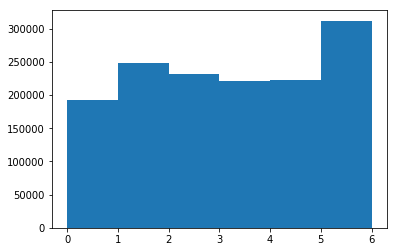

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.hist(stops["date"].dt.weekday, bins=6)

Monday is 0, and Sunday is 6. It looks like Sunday has the most stops, and Monday the least. This could also be a data quality issue where invalid dates resulted in Sunday. We would dig more deeply into the 'date_of_stop' column to figure it out.

We can also plot out the most common traffic stop times

(array([ 79033.,  64258.,  48949.,  32719.,  19698.,  13025.,  21211.,
         50618.,  75577.,  70538.,  72160.,  60037.,  54351.,  55717.,
         57697.,  49378.,  68454.,  72035.,  57098.,  50281.,  55555.,
         79643., 112124., 109110.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <a list of 24 Patch objects>)

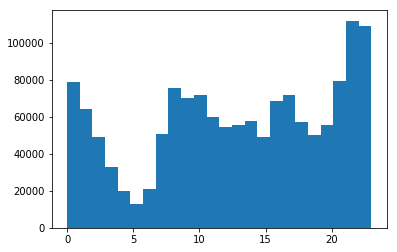

In [18]:
plt.hist(stops["date"].dt.hour, bins=24)

The most stops happen around midnight, and the fewest around 5am. This might make sense, as people are driving home from bars and dinners late and night, and may be impaired.

## Subsetting The Stops

We can map out the traffic stops. Because mapping is very intensive in terms of CPU resources and memory, we need to filter down the rows we use from stops first

We will select allrows that came in the past year

In [19]:
last_year = stops[stops["date"] > datetime.datetime(year=2015, month=2, day=18)]

We will further narrow this down, and only select rows that occurred during rush hour

In [24]:
morning_rush = last_year[(last_year["date"].dt.weekday < 5) & (last_year["date"].dt.hour > 5) & (last_year["date"].dt.hour < 10)]

In [25]:
# show number of rows for filtered data (morning rush hour rows)
morning_rush.shape

(106693, 21)

In [23]:
# show number of rows for last year (all times of the day - not just rush hour)
last_year.shape

(834692, 21)

Using the 'folium' package, we can visualize where all the stops occurred. (Folium allows you to easily create interactive maps in Python by leveraging 'leaflet'). 

To preserve performance, we'll only visualize the first 1000 rows of 'morning_rush'

In [26]:
# import the packages
import folium
from folium import plugins

In [29]:
stops_map = folium.Map(location=[39.0836, -77.1483], zoom_start=11)
marker_cluster = MarkerCluster().add_to(stops_map)
for name, row in morning_rush.iloc[:1000].iterrows():
    folium.Marker([row["longitude"], row["latitude"]], popup=row["description"]).add_to(marker_cluster)
stops_map.create_map('stops.html')
stops_map

NameError: name 'MarkerCluster' is not defined

In [28]:
print(folium.__version__)

0.7.0


In [30]:
stops_map = folium.Map(location=[39.0836, -77.1483], zoom_start=11)

In [34]:
from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(stops_map)

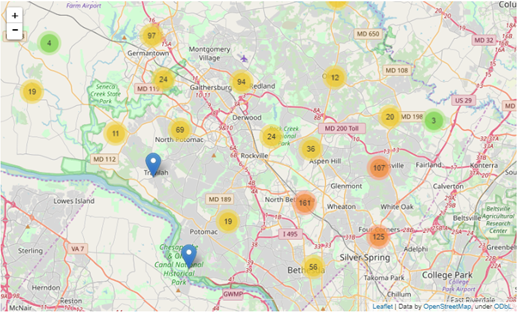

In [31]:
stops_map

In [ ]:
for name, row in morning_rush.iloc[:1000].iterrows():
    folium.Marker([row["longitude"], row["latitude"]], popup=row["description"]).add_to(marker_cluster)
stops_map.save('stops.html')
stops_map

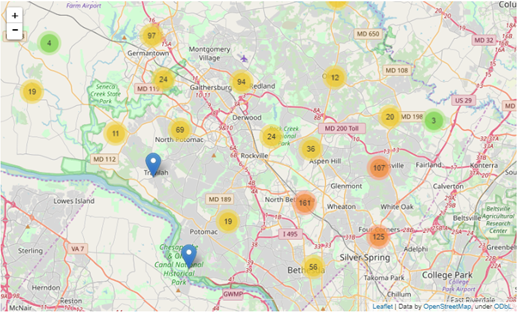

This shows that many traffic stops are concentrated around the bottom right of the county. We can extend our analysis further with a heatmap

In [ ]:
stops_heatmap = folium.Map(location=[39.0836, -77.1483], zoom_start=11)
stops_heatmap.add_children(plugins.HeatMap([[row["longitude"], row["latitude"]] for name, row in morning_rush.iloc[:1000].iterrows()]))
stops_heatmap.save("heatmap.html")
stops_heatmap

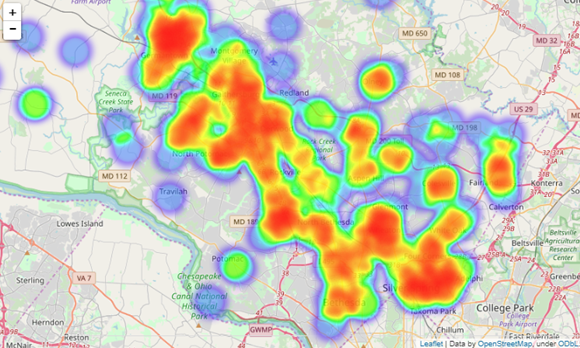